# 14 - 双重差分

## 巴西南部的三个广告牌


我记得当我从事营销工作时，互联网广告是一个很棒的途径。不是因为它非常有效（尽管确实如此），而是因为很容易知道它是否有效。通过在线营销，您可以了解哪些客户看到了广告，并且您可以使用 cookie 跟踪他们，看看他们是否最终出现在您的目标网页上或点击了某个下载按钮。您还可以使用机器学习来寻找与您的客户非常相似的潜在客户，并仅向他们展示广告。从这个意义上说，在线营销非常精确：您只针对您想要的人，您可以查看他们是否按照您的意愿做出反应。

但并不是每个人都容易受到网络营销的影响。有时你不得不求助于不太精确的技术，比如电视宣传或在街上放置广告牌。通常，营销渠道的多样性是营销部门所寻求的。但是，如果在线营销是捕捉特定类型金枪鱼的专业钓鱼竿，那么广告牌和电视就是你向鱼群扔的大网，并希望至少能钓到一些大鱼。广告牌和电视广告的另一个问题是很难知道它们的效果如何。当然，您可以在某处放置广告牌之前和之后测量购买量，或任何您想驱动的东西。如果有增加，则有一些证据表明营销是有效的。但是你怎么知道这种增加是否不仅仅是你产品认知度的某种自然趋势？换句话说，如果你一开始没有设置广告牌，你怎么知道反事实的 \\(Y_0\\) 会发生什么？

![img](./data/img/diff-in-diff/secrets.png)

回答这些类型问题的一种技术是双重差分，或简称 diff-in-diff。 Diff-in-diff 通常用于评估宏观干预的影响，例如移民对失业的影响、枪支法变化对犯罪率的影响，或者仅仅是营销活动导致的用户参与度差异。在所有这些情况下，您在干预之前和之后都有一段时间，并且您希望从总体趋势中解开干预的影响。作为一个激励性的例子，让我们看一个与我必须回答的问题类似的问题。

为了弄清楚广告牌作为营销渠道的效果如何，我们在南里奥格兰德州（Rio Grande do Sul）首府阿雷格里港市（city of Porto Alegre）放置了 3 个广告牌。我们想看看这是否会增加我们储蓄账户的存款。对于那些不太熟悉巴西地理的人来说，南里奥格兰德州是该国南部的一部分，是最发达的地区之一。

考虑到这一点，我们决定还查看来自南部的另一个首府——圣卡塔琳娜州（Santa Catarina）首府弗洛里亚诺波利斯（Florianopolis）的数据。这个想法是，我们可以使用弗洛里亚诺波利斯作为控制样本来估计与阿雷格里港相比的反事实 \\(Y_0\\) （顺便说一下，这不是真正的实验，真的实验是保密的，但这个想法非常相似)。我们在阿雷格里港的广告牌放置了一整个六月。我们拥有的数据如下所示：

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf


%matplotlib inline

style.use("fivethirtyeight")

In [2]:
data = pd.read_csv("data/billboard_impact.csv")
data.head()

,deposits,poa,jul
0,42,1,0
1,0,1,0
2,52,1,0
3,119,1,0
4,21,1,0


请记住，存款是我们的结果变量，是我们希望通过广告牌增加的目标。 POA 是阿雷格里港市的虚拟指标。当它为零时，表示样本来自弗洛里亚诺波利斯。 Jul 是 7 月份或干预后时期的虚拟变量。当它为零时，它指的是干预前时期 5 月的样本。

## DID 估计器

为了避免混淆时间和干预，从现在开始，我将用 D 表示治疗，用 T 表示时间。设 \\(Y_D(T)\\) 是干预 D 在时间段 T 的潜在结果。在我们有能力观察反事实的理想世界中，我们将通过以下方式估计干预的效果：

$
\hat{ATET} = E[Y_1(1) - Y_0(1)|D=1]
$

换句话说，因果效应是干预后干预期间的结果减去干预后期间的结果，但在没有治疗的情况下。当然，我们无法衡量这一点，因为 \\(Y_0(1)\\) 是反事实的。

解决此问题的一种方法是进行前后比较。

$
\hat{ATET} = E[Y(1)|D=1] - E[Y(0)|D=1]
$

在我们的示例中，我们将比较放置广告牌之前和之后 POA 的平均存款。

In [3]:
poa_before = data.query("poa==1 & jul==0")["deposits"].mean()

poa_after = data.query("poa==1 & jul==1")["deposits"].mean()

poa_after - poa_before

41.04775

该估计器告诉我们，我们应该预计在干预后存款将增加 41,04 雷亚尔。但是我们可以相信这个吗？

请注意 \\(E[Y(0)|D=1]=E[Y_0(0)|D=1]\\)，即在**干预之前**，被干预对象的观察结果是等于干预前其对应的反事实结果。由于我们使用\\(E[Y_0(1)|D=1]\\)来估计干预后的反事实 ，因此上面的估计假设 \\(E[Y_0(1)| D=1] = E[Y_0(0)|D=1]\\)。

就是说，在不干预的情况下，后期的结果与开始阶段的结果相同。但是如果您的结果变量遵循任何趋势，第一句的假设显然是错误的。例如，假设 POA 的存款有上升趋势，那么\\(E[Y_0(1)|D=1] > E[Y_0(0)|D=1]\\)，即后一时期即使在没有干预的情况下，其结果也比开始阶段的要大。使用类似的论点，如果 Y 的趋势下降，\\(E[Y_0(1)|D=1] < E[Y_0(0)|D=1]\\)。这是为了表明直接进行前后比较的方法不是一个很好的估计量。

另一个想法是将干预组与未接受干预的对照组进行比较：

$
\hat{ATET} = E[Y(1)|D=1] - E[Y(1)|D=0]
$

在我们的示例中，将比较 POA 与 Florianopolis 在干预后时期的存款。

In [4]:
fl_after = data.query("poa==0 & jul==1")["deposits"].mean()
poa_after - fl_after

-119.10175000000001

该估计器告诉我们，这个营销活动会带来损害，客户将减少 119.10 雷亚尔的存款。

注意 \\(E[Y(1)|D=0]=E[Y_0(1)|D=0]\\)。由于我们使用 \\(E[Y(1)|D=0]\\) 来估计干预后实验组的反事实，假设我们可以像这样替换缺失的反事实：\\(E[ Y_0(1)|D=0] = E[Y_0(1)|D=1]\\)。但请注意，只有当两组的基线水平非常相似时，这才是正确的。例如，如果弗洛里亚诺波利斯的存款比阿雷格里港多，这将不正确，因为 \\(E[Y_0(1)|D=0] > E[Y_0(1)|D=1]\\)。另一方面，如果弗洛里亚诺波利斯的存款水平较低，我们将有 \\(E[Y_0(1)|D=0] < E[Y_0(1)|D=1]\\)。

同样，这仍然不是一个好主意。为了解决这个问题，我们可以同时使用空间和时间比较。这就是双重差分方法的思想。它通过以下方式替换缺少的反事实来工作：

$
E[Y_0(1)|D=1] = E[Y_1(0)|D=1] + (E[Y_0(1)|D=0] - E[Y_0(0)|D=0])
$

这样做是在 ** 干预之前 ** 获取实验对象并向其添加趋势分量，该分量使用控制组 \\(E[Y_0(1)|T=0] - E[Y_0(0) |T=0]\\)来估计得到。换句话说，这表示，如果没有干预发生，实验组在**干预后**会看起来就像**干预前的**实验组加上一个与对照组增长量相同的增长因子。

需要注意的很重要的一点是，这是假设了实验组和控制组在时间上的趋势是相同的：

$
E[Y_0(1) - Y_0(0)|D=1] = E[Y_0(1) - Y_0(0)|D=0]
$

其中等式左侧是反事实趋势。现在，我们可以替换干预效果定义中估计的反事实 \\(E[Y_1(1)|D=1] - E[Y_0(1)|D=1]\\)

$
\hat{ATET} = E[Y(1)|D=1] - (E[Y(0)|D=1] + (E[Y(1)|D=0] - E[Y(0) |D=0])
$

如果我们重新排列这些项，我们会得到经典的 Diff-in-Diff 估计量。

$
\hat{ATET} = (E[Y(1)|D=1] - E[Y(1)|D=0]) - (E[Y(0)|D=1] - E[Y(0 )|D=0])
$

它之所以得名，是因为它区分了干预前后实验组与对照组之间的差异。

这是对应的代码。

In [5]:
fl_before = data.query("poa==0 & jul==0")["deposits"].mean()

diff_in_diff = (poa_after-poa_before)-(fl_after-fl_before)
diff_in_diff

6.524557692307688

Diff-in-Diff 告诉我们，我们应该预计每位客户的存款将增加 6.52 雷亚尔。 请注意，diff-in-diff 所做的假设比其他 2 个估计量更合理。 它只是假设两个城市之间的增长模式是相同的。 但这并不要求它们具有相同的基本水平，也不要求趋势为零。

为了可视化 diff-in-diff 的作用，我们可以将未处理的增长趋势投影到已处理的增长趋势，以查看反事实，即如果没有干预，我们应该预期的存款数量。

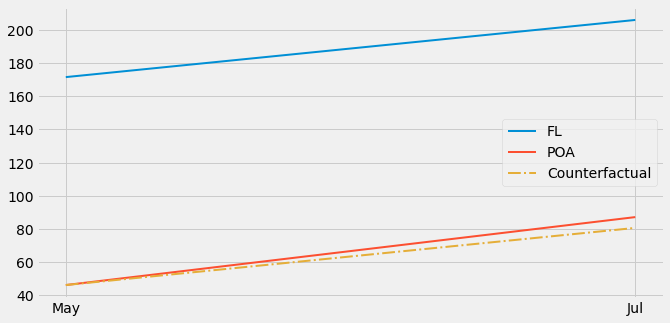

In [6]:
plt.figure(figsize=(10,5))
plt.plot(["May", "Jul"], [fl_before, fl_after], label="FL", lw=2)
plt.plot(["May", "Jul"], [poa_before, poa_after], label="POA", lw=2)

plt.plot(["May", "Jul"], [poa_before, poa_before+(fl_after-fl_before)],
         label="Counterfactual", lw=2, color="C2", ls="-.")

plt.legend();

看到红色和黄色虚线之间的细微差别了吗？如果你真的专注，你可以看到阿雷格里港小小的干预效果。

![img](./data/img/diff-in-diff/cant-read.png)


现在，您可能会问自己“我能相信这个估计器多少？我有权了解对应的标准误！”。这是有道理的，因为没有标准误的估计器看起来很傻。为此，我们将使用一个使用回归的巧妙技巧。具体来说，我们将估计以下线性模型

$
Y_i = \beta_0 + \beta_1 POA_i + \beta_2 Jul_i + \beta_3 POA_i*Jul_i + e_i
$

请注意，\\(\beta_0\\) 是控制组的基线。在我们的例子中，是 5 月份弗洛里亚诺波利斯的存款水平。如果我们将干预过的城市对应的虚拟变量设为1，我们会得到 \\(\beta_1\\)。所以 \\(\beta_0 + \beta_1\\) 是阿雷格里港 5 月份干预前的基线，而 \\(\beta_1\\) 是阿雷格里港基线在弗洛里亚诺波利斯之上的增量。如果我们关闭 POA 虚拟变量并打开 7 月虚拟变量，我们会得到 \\(\beta_0 + \beta_2\\)，即干预期后 Florianópolis 在 7 月的水平。 \\(\beta_2\\) 是控制组的趋势，因为我们将它添加到基线之上以获得干预后时期的控制水平。回顾一下，\\(\beta_1\\) 是我们从处理到控制得到的增量，\\(\beta_2\\) 是我们从之前的时期到之后的时期得到的增量干涉。最后，如果我们打开两个虚拟变量，我们会得到 \\(\beta_3\\)。 \\(\beta_0 + \beta_1 + \beta_2 + \beta_3\\) 是干预后阿雷格里港的水平。所以 \\(\beta_3\\) 是从 5 月到 7 月以及从弗洛里亚诺波利斯到 POA 的增量影响。换句话说，它是差异估计量的差异。

如果您不相信我，请自己检查。你应该得到与我们上面得到的完全相同的数字。还要注意我们是如何得到我们想要的标准误的。

In [7]:
smf.ols('deposits ~ poa*jul', data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,171.6423,2.363,72.625,0.000,167.009,176.276
poa,-125.6263,4.484,-28.015,0.000,-134.418,-116.835
jul,34.5232,3.036,11.372,0.000,28.571,40.475
poa:jul,6.5246,5.729,1.139,0.255,-4.706,17.755


## 非平行趋势

Diff-in-Diff 实际应用中的一个明显问题是不能满足平行趋势假设。如果实验组的增长趋势与对照组的趋势不同，则 diff-in-diff 将有偏差。这是非随机数据的常见问题，其中对某区域进行干预的决定是基于其对干预反应的良好潜力，或者当干预针对业务表现不佳的区域时。以我们的营销为例。我们决定在阿雷格里港测试广告牌，并不是为了检查广告牌的总体效果。原因只是因为那里的销售表现不佳。也许在线营销在那里不起作用。在这种情况下，假设没有广告牌，我们在阿雷格里港潜在看到的增长可能低于我们在其他城市观察到的增长。这会导致我们低估那里的广告牌的影响。

检查是否发生这种情况的一种方法是使用过去时期的数据绘制趋势。例如，假设 POA 有小幅下降趋势，但 Florianopolis 呈急剧上升趋势。在这种情况下，显示以前的时期将揭示这些趋势，我们会知道 Diff-in-Diff 不是可靠的估计量。

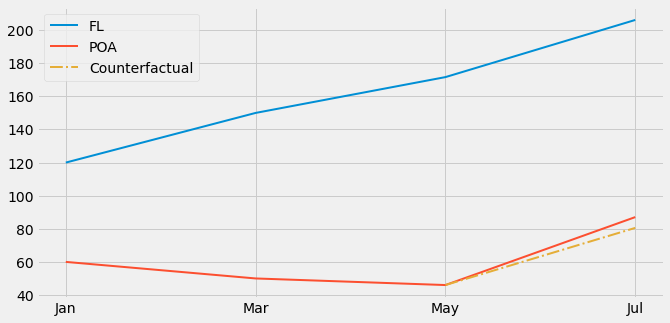

In [8]:
plt.figure(figsize=(10,5))
x = ["Jan", "Mar", "May", "Jul"]

plt.plot(x, [120, 150, fl_before,  fl_after], label="FL", lw=2)
plt.plot(x, [60, 50, poa_before, poa_after], label="POA", lw=2)

plt.plot(["May", "Jul"], [poa_before, poa_before+(fl_after-fl_before)], label="Counterfactual", lw=2, color="C2", ls="-.")

plt.legend();

我们将看到如何使用合成控制来解决这个问题。它将利用多个城市构造一个密切贴合我们感兴趣城市趋势的合成城市。但是现在，请记住，在应用 diff-in-diff 时，您总是需要检查是否有平行趋势。

![img](./data/img/diff-in-diff/non-parallel.png)

值得一提的最后一个问题是，如果您只有聚合数据，您将无法在使用 Diff-in-Diff 估计器的时候估计置信区间。例如，假设您没有关于我们来自 Florianópolis 或 Porto Alegre 的每个客户所做的事情的数据。相反，您只有两个城市干预前后的平均存款。在这种情况下，您仍然可以通过 Diff-in-Diff 估计因果效应，但您不会知道它的方差。那是因为数据中的所有可变性都在聚合中被压扁了。

## 关键思想

当我们在更宏观的实体（学校、城市、州、国家......）估计因果效应时，我们探索了一种广泛应用的技术。双重差分观察干预前后实验组的变化，并将结果的趋势与对照组的结果趋势进行比较。在这里，我们看到了如何将其应用于评估特定城市营销活动的效果。

最后，我们研究了如果实验组和对照组之间的趋势不同，Diff-in-Diff 是如何失败的。我们还了解了如果我们只有聚合数据，diff-in-diff 将如何产生问题。